In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Load and Preprocess Data (Ensuring consistency with previous steps)
df = pd.read_csv('../data/raw/M2SL.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)
df.rename(columns={'M2SL': 'M2'}, inplace=True)

# Calculate Monthly Growth Rate (Log-Difference) * 100
df['M2_Growth'] = np.log(df['M2']).diff() * 100
df_clean = df.dropna()

# 2. Feature Engineering: Create Lag Features
# We transform the time series problem into a supervised learning problem.
# Use past 12 months (lags) to predict the current month.
def create_lag_features(data, n_lags=12):
    df_ml = pd.DataFrame(data)
    # Create columns for each lag (t-1, t-2, ..., t-n)
    columns = [df_ml.shift(i) for i in range(1, n_lags + 1)]
    df_lags = pd.concat(columns, axis=1)
    
    # Rename columns to meaningful names
    df_lags.columns = [f'Lag_{i}' for i in range(1, n_lags + 1)]
    
    # Add the target variable (current value at t)
    df_lags['Target'] = df_ml
    
    # Drop rows with NaN values created by shifting
    df_lags.dropna(inplace=True)
    return df_lags

# Apply transformation
n_lags = 12 
data_ml = create_lag_features(df_clean['M2_Growth'], n_lags)

# 3. Train-Test Split (Chronological)
# We calculate the split point to match the 80/20 split used in ARIMA
n_obs_original = len(df_clean)
n_test_obs = int(n_obs_original * 0.2)
# We use the index to split strictly by time
split_date = df_clean.index[-n_test_obs]

train_ml = data_ml[data_ml.index < split_date]
test_ml = data_ml[data_ml.index >= split_date]

# Separate Features (X) and Target (y)
X_train = train_ml.drop('Target', axis=1)
y_train = train_ml['Target']
X_test = test_ml.drop('Target', axis=1)
y_test = test_ml['Target']

print("Data preparation complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")

Data preparation complete.
Training samples: 629
Test samples:     160


Training Random Forest Regressor...

Random Forest Performance:
RMSFE: 0.6503
MAE:   0.3038


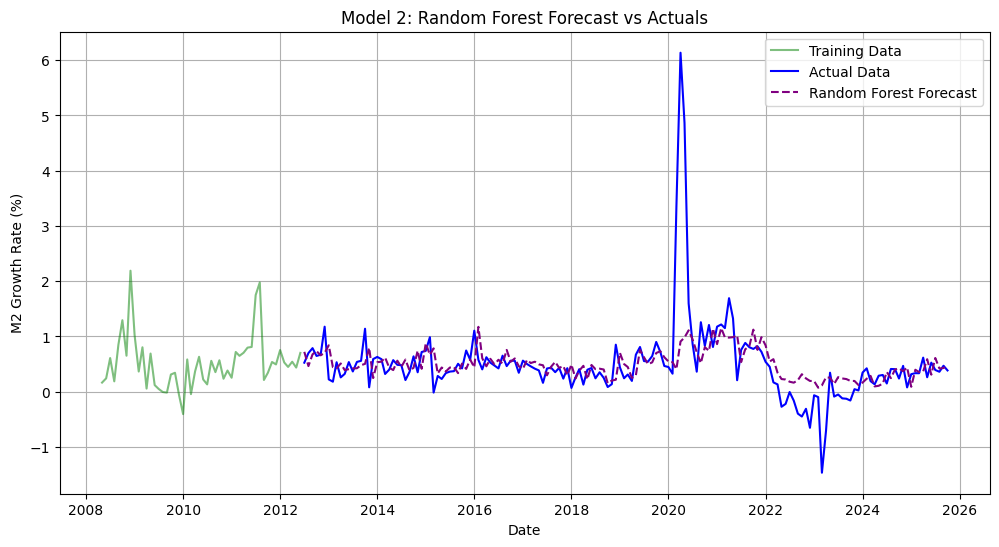

In [6]:
# 4. Train Random Forest Model
print("Training Random Forest Regressor...")

# Initialize model with 100 trees and a fixed random state for reproducibility
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Forecasting
# Since X_test contains actual past values (lags), 
# predictions here effectively represent 1-step ahead forecasts.
rf_predictions = rf_model.predict(X_test)

# Organize results in a DataFrame
rf_forecast_df = pd.DataFrame({
    'Actual': y_test,
    'RF_Forecast': rf_predictions
}, index=y_test.index)

# 6. Evaluation Metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmsfe = np.sqrt(rf_mse)
rf_mae = np.mean(np.abs(y_test - rf_predictions))

print(f"\nRandom Forest Performance:")
print(f"RMSFE: {rf_rmsfe:.4f}")
print(f"MAE:   {rf_mae:.4f}")

# 7. Visualization
plt.figure(figsize=(12, 6))
# Plot last 50 observations of training data for context
plt.plot(train_ml.index[-50:], train_ml['Target'][-50:], label='Training Data', color='green', alpha=0.5)
plt.plot(test_ml.index, test_ml['Target'], label='Actual Data', color='blue')
plt.plot(rf_forecast_df.index, rf_forecast_df['RF_Forecast'], label='Random Forest Forecast', color='purple', linestyle='--')

plt.title('Model 2: Random Forest Forecast vs Actuals')
plt.ylabel('M2 Growth Rate (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

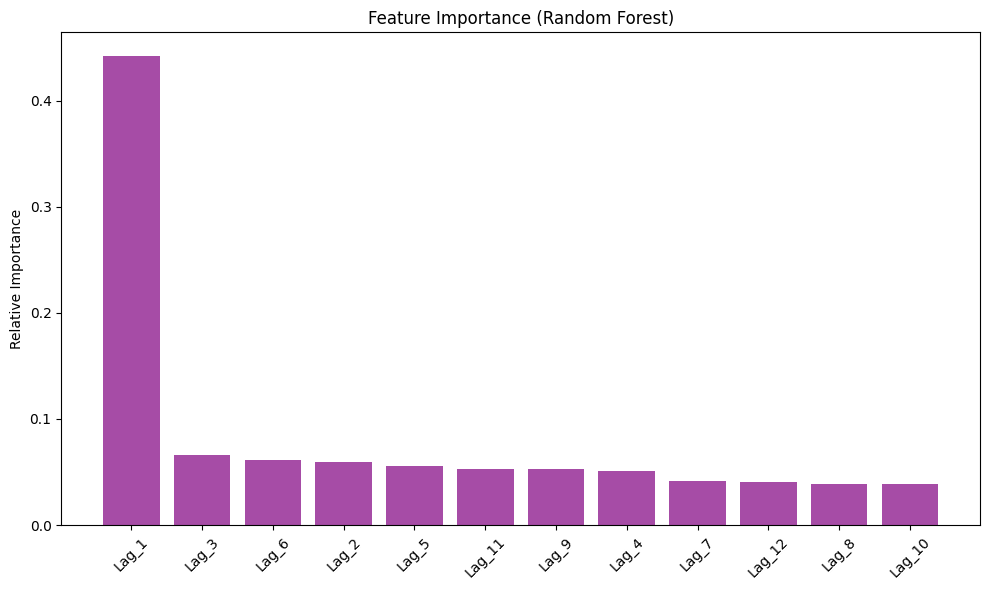

In [7]:
# 8. Feature Importance Analysis
# This plot shows which lags have the most predictive power.
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X_train.shape[1]), importances[indices], align='center', color='purple', alpha=0.7)
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=45)
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.show()